In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")

In [3]:
series = robberies_in_boston["Count"]

In [4]:
series_stat = boxcox(series, 0)

In [5]:
series_stat = series_stat[1:] - series_stat[:-1]

In [6]:
series_stat = pd.Series(series_stat)

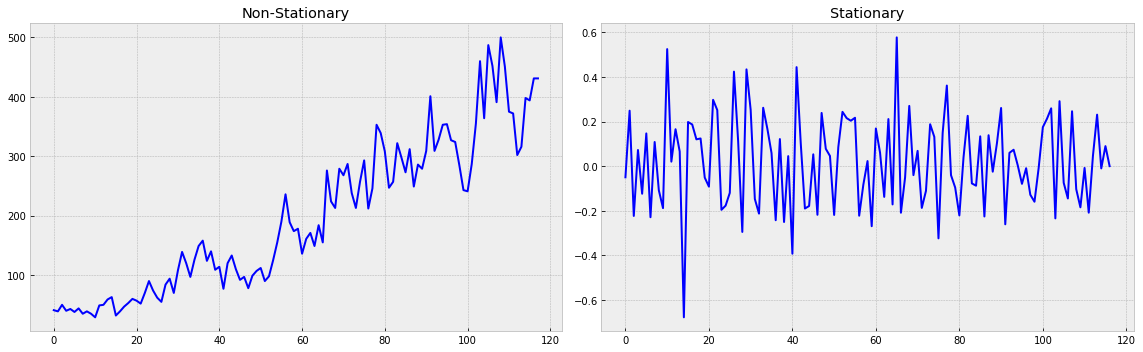

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 5))
    layout = (1, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    series.plot(ax=ts_ax, color='blue')
    ts_ax.set_title('Non-Stationary')
    ts_ax = plt.subplot2grid(layout, (0, 1))
    series_stat.plot(ax=ts_ax, color='blue')
    ts_ax.set_title('Stationary')
        
    plt.tight_layout()

### Не стационарный

Для не стационарного временного ряда будем использовать двойное экспоненциальное сглаживание, так как есть тренд.

In [8]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [9]:
def plot_dema(alpha, beta, series):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

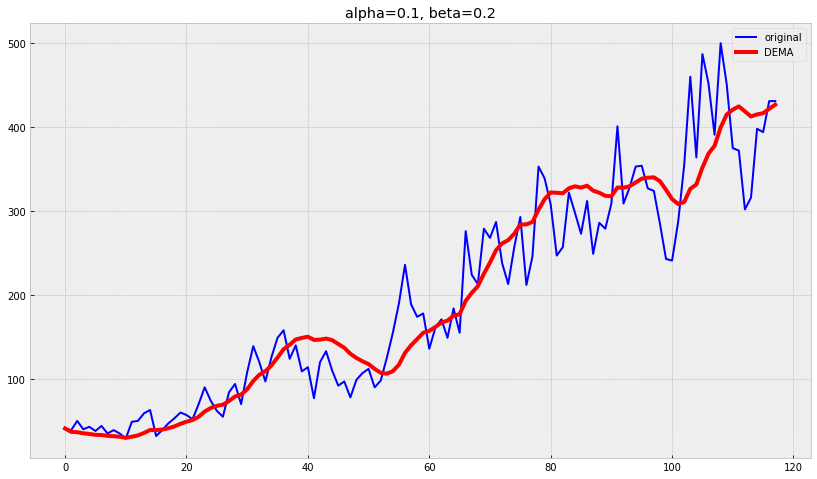

In [10]:
plot_dema(0.1, 0.2, series)

In [18]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)
    
    result = pd.Series(result)
    return result.append(pd.Series(preds), ignore_index=True), pd.Series(result)

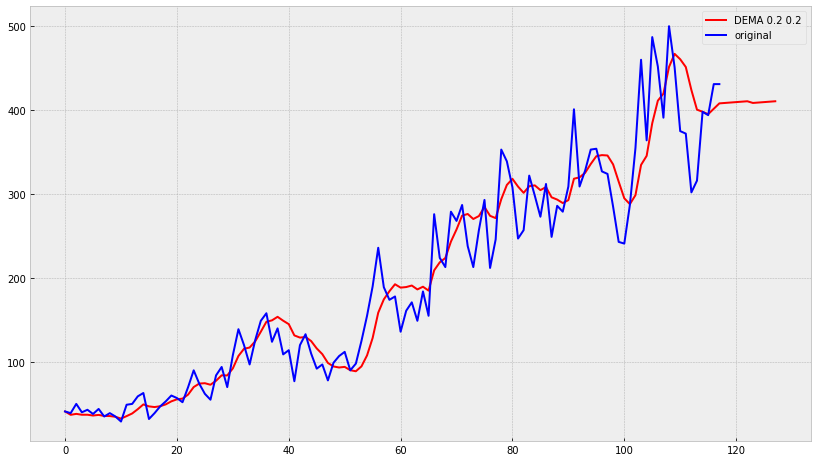

In [19]:
alphas = [0.2]
bettas = [0.2]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(series, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Теперь воспользуемся кросс валидацией, чтобы найти оптимальные значения для алгоритма

In [13]:
train, val = series[:100], series[100:]

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = double_ema_with_preds(train_split_ts, alpha, beta, len(test_split))[0]
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [23]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [25]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 1309.4422990698743
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05,  3.63797881e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 10
   status: 0
  success: True
        x: array([0.83638136, 0.48014136])


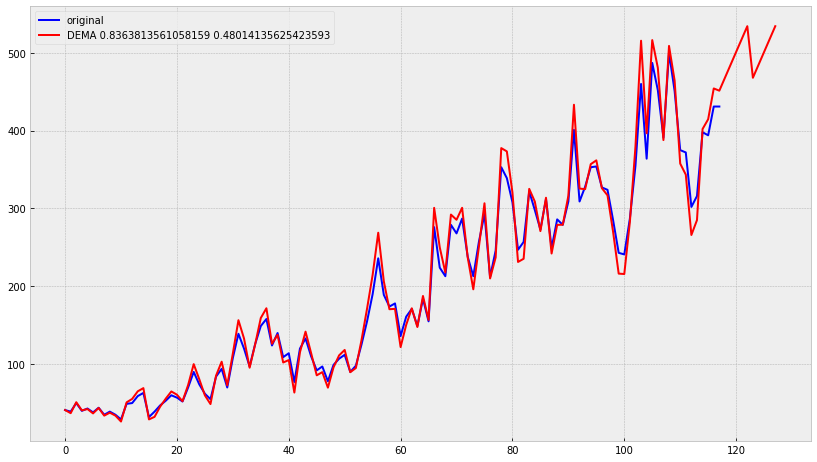

In [32]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    ser, _ = double_ema_with_preds(series, alpha_opt, beta_opt, 5)
    plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.legend()

### Stationary

Для стационарного ряда будем использовать простое скользящее средние, чтобы определить тренд.

In [33]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

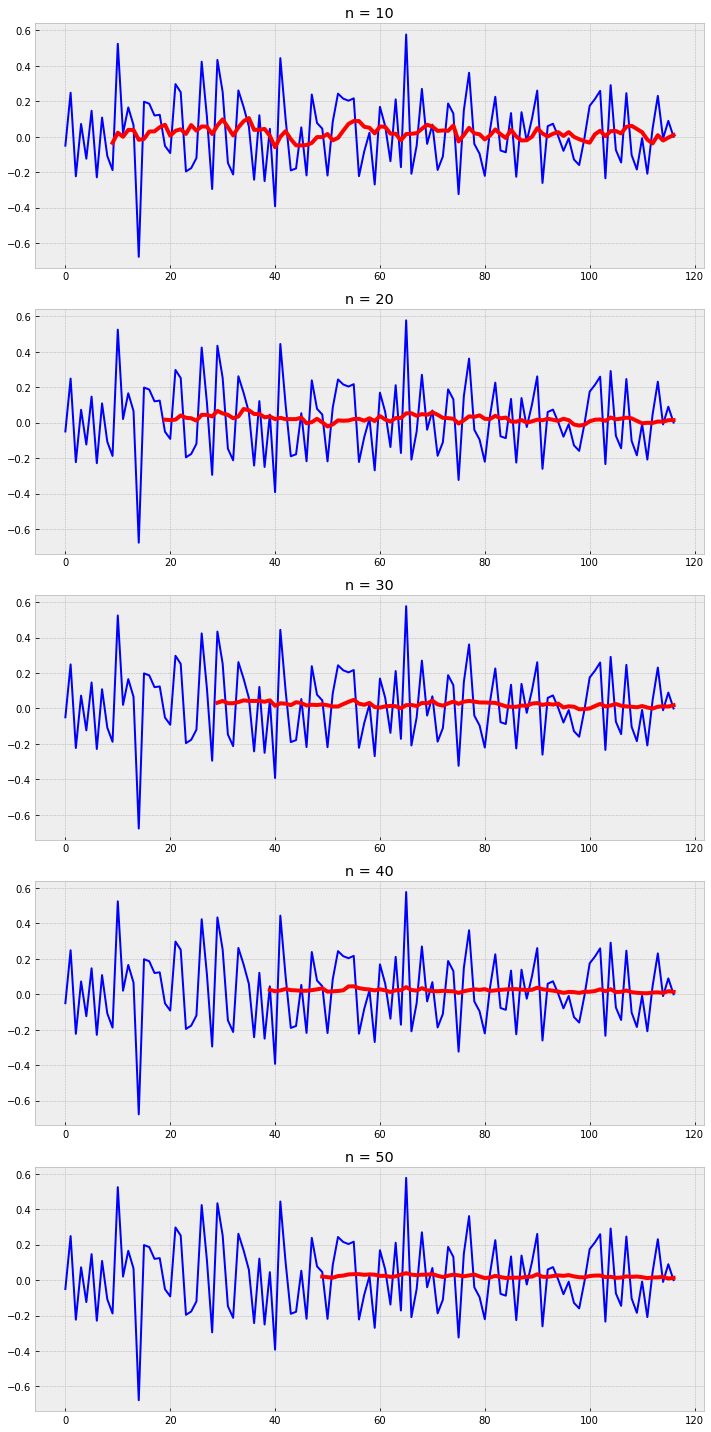

In [47]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 20))
    layout = (5, 1)
    for i in range(1, 6):
        x = i
        ser = moving_average(series_stat, x*10)
        ts_ax = plt.subplot2grid(layout, (x-1, 0))
        series_stat.plot(ax=ts_ax, color='blue', label='original')
        ser.plot(ax=ts_ax, color='red', linewidth='4', label='Moving Average')
        ts_ax.set_title(f'n = {x*10}')        
        
    plt.tight_layout()